# PassiveDNS Analysis Workshop

PassiveDNS is a comprehensive database that collects and stores DNS resolution data from various sources across the internet. This service provides historical DNS records that are invaluable for threat intelligence, incident response, and security research.

## What is PassiveDNS?

PassiveDNS provides historical and real-time information about DNS resolutions, including:
- Domain-to-IP address mappings (A/AAAA records)
- Reverse DNS lookups (PTR records) 
- Mail server information (MX records)
- Name server data (NS records)
- Historical timeline of DNS changes
- First and last seen timestamps for all records

## Documentation

- Main Documentation: https://www.circl.lu/services/passive-dns/
- API Reference: https://pypdns.readthedocs.io/en/latest/api_reference.html
- Data Sources: DNS resolvers, honeypots, and network sensors worldwide

## Learning Objectives

By the end of this workshop, you will be able to:
1. Query DNS records for domains and analyze their history
2. Perform reverse DNS lookups to map IPs to domains
3. Filter DNS records by type for targeted analysis
4. Analyze DNS record patterns and distributions
5. Create timelines of domain activity and infrastructure changes

## Exercises

### PassiveDNS API Setup

Before we begin exploring PassiveDNS data, we need to set up our authentication credentials. The PassiveDNS service requires user authentication to access the comprehensive DNS record database.

**Prerequisites:**
- Valid PassiveDNS account credentials
- Network access to https://www.circl.lu
- Python pypdns library (should be pre-installed)

**Setup Instructions:**
1. Obtain your PassiveDNS username and API key from your account
2. Run the cell below to securely input your credentials
3. The PyPDNS client will be configured for all subsequent API calls

**Security Note:** Using `getpass` ensures your credentials are not displayed in the notebook output.

In [1]:
import pypdns
import json
import getpass

# Securely collect PassiveDNS credentials
print("Setting up PassiveDNS API authentication...")
PASSIVE_DNS_USER = getpass.getpass("Enter your PassiveDNS Username: ")
PASSIVE_DNS_KEY = getpass.getpass("Enter your PassiveDNS API Key: ")

# Create PassiveDNS client with authentication
pdns = pypdns.PyPDNS(basic_auth=(PASSIVE_DNS_USER, PASSIVE_DNS_KEY))

print("Authentication configured successfully!")
print("Ready to query PassiveDNS database.")

Setting up PassiveDNS API authentication...


Enter your PassiveDNS Username:  ········
Enter your PassiveDNS API Key:  ········


Authentication configured successfully!
Ready to query PassiveDNS database.


### Exercise 1.0: Retrieve DNS Records for a Domain

**Objective:** Query all available DNS records for a specific domain to understand its infrastructure.

**What DNS Records Tell Us:**
DNS records provide crucial information about domain infrastructure:
- **A Records:** IPv4 addresses where the domain resolves
- **AAAA Records:** IPv6 addresses for the domain
- **MX Records:** Mail server configurations
- **NS Records:** Authoritative name servers
- **CNAME Records:** Domain aliases and redirections

**Why This Matters:**
- **Infrastructure Mapping:** Understand how domains are hosted and configured
- **Threat Intelligence:** Track changes in malicious domain infrastructure
- **Incident Response:** Investigate suspicious domains and their hosting patterns
- **Historical Analysis:** See how domain configurations have evolved over time

**About This Domain:**
We're querying `circl.lu`, which is CIRCL's main domain. This will show us the various DNS records associated with this security research organization.

**API Endpoint:** `https://www.circl.lu/pdns/query/[host]`

**Expected Output:**
- Complete DNS record history for the domain
- Timestamps showing when records were first and last observed
- Different record types (A, AAAA, MX, NS, etc.)

**Try It:** Run the cell below to explore all DNS records for the domain.

In [2]:
# Query all DNS records for a domain
domain = 'circl.lu'
print(f"Retrieving DNS records for domain: {domain}")
print("This will show all historical DNS records in the database...")

try:
    records = list(pdns.iter_query(q=domain))
    
    if records:
        print(f"Successfully retrieved {len(records)} DNS records!")
        print(f"\nShowing detailed DNS record information:")
        print("="*60)
        
        for i, record in enumerate(records, 1):
            print(f"\nRecord {i}:")
            print(json.dumps(record.record, indent=2))
            
        # Basic analysis
        record_types = set(r.rrtype for r in records)
        print(f"\nRecord Types Found: {', '.join(sorted(record_types))}")
        print(f"Total Records: {len(records)}")
        
    else:
        print("No DNS records found for this domain.")
        
except Exception as e:
    print(f"Error querying DNS records: {e}")
    print("Please check your credentials and network connection.")

Retrieving DNS records for domain: circl.lu
This will show all historical DNS records in the database...
Successfully retrieved 66 DNS records!

Showing detailed DNS record information:

Record 1:
{
  "rrname": "185.194.93.14",
  "rrtype": "A",
  "rdata": "circl.lu",
  "time_first": 1696798385,
  "time_last": 1762835411,
  "count": 7049,
  "origin": "https://www.circl.lu/pdns/"
}

Record 2:
{
  "rrname": "2a00:5980:93::14",
  "rrtype": "AAAA",
  "rdata": "circl.lu",
  "time_first": 1696798385,
  "time_last": 1762761447,
  "count": 400,
  "origin": "https://www.circl.lu/pdns/"
}

Record 3:
{
  "rrname": "10 cppy.circl.lu",
  "rrtype": "MX",
  "rdata": "circl.lu",
  "time_first": 1696786636,
  "time_last": 1762829121,
  "count": 9623,
  "origin": "https://www.circl.lu/pdns/"
}

Record 4:
{
  "rrname": "ns-a.eurodns.com",
  "rrtype": "NS",
  "rdata": "circl.lu",
  "time_first": 1713474705,
  "time_last": 1762175641,
  "count": 359,
  "origin": "https://www.circl.lu/pdns/"
}

Record 5:
{
 

### Exercise 1.1: Filter DNS Records by Type

**Objective:** Query only specific types of DNS records to focus on particular infrastructure elements.

**Understanding A Records:**
A records are the most fundamental DNS record type, mapping domain names to IPv4 addresses. They tell us:
- **Current IP Addresses:** Where the domain currently resolves
- **Historical IPs:** Previous hosting locations and infrastructure changes
- **Load Balancing:** Multiple A records can indicate load-balanced services
- **Geographic Distribution:** Different IPs may serve different regions

**Use Cases for A Record Analysis:**
- **Malware Analysis:** Track command and control server IPs
- **Infrastructure Tracking:** Monitor changes in hosting providers
- **Threat Hunting:** Identify suspicious IP patterns
- **Business Intelligence:** Understand competitor hosting strategies

**Why Filter by Record Type:**
Filtering allows focused analysis without noise from other record types like MX, NS, or TXT records. This is especially useful when:
- Investigating specific infrastructure components
- Building IP reputation databases
- Tracking hosting patterns over time

**API Endpoint:** `https://www.circl.lu/pdns/query/[host]` with rrtype filter

**Expected Output:**
- Only A records for the specified domain
- Historical timeline of IP address changes
- First and last seen timestamps for each IP

**Analysis Questions:**
- How many different IPs has this domain used?
- Are there patterns in the IP address changes?
- Do the IPs belong to the same hosting provider or ASN?

In [3]:
# Query only A records for a domain
domain = 'circl.lu'
print(f"Retrieving A records for domain: {domain}")
print("Filtering for IPv4 address records only...")

try:
    records = list(pdns.iter_query(q=domain, filter_rrtype='A'))
    
    if records:
        print(f"Successfully retrieved {len(records)} A records!")
        print(f"\nDetailed A Record Information:")
        print("="*50)
        
        ip_addresses = set()
        for i, record in enumerate(records, 1):
            print(f"\nA Record {i}:")
            print(json.dumps(record.record, indent=2))
            
            # Collect IP addresses for analysis
            if hasattr(record, 'rdata'):
                ip_addresses.add(record.rdata)
        
        # Analysis summary
        print(f"\nA Record Analysis Summary:")
        print(f"Unique IP addresses found: {len(ip_addresses)}")
        if ip_addresses:
            print("IP addresses:")
            for ip in sorted(ip_addresses):
                print(f"  - {ip}")
                
        print(f"Total A record observations: {len(records)}")
        
    else:
        print("No A records found for this domain.")
        
except Exception as e:
    print(f"Error querying A records: {e}")
    print("Please verify the domain name and your API credentials.")

Retrieving A records for domain: circl.lu
Filtering for IPv4 address records only...
Successfully retrieved 1 A records!

Detailed A Record Information:

A Record 1:
{
  "rrname": "185.194.93.14",
  "rrtype": "A",
  "rdata": "circl.lu",
  "time_first": 1696798385,
  "time_last": 1762835411,
  "count": 7049,
  "origin": "https://www.circl.lu/pdns/"
}

A Record Analysis Summary:
Unique IP addresses found: 1
IP addresses:
  - circl.lu
Total A record observations: 1


### Exercise 1.2: Reverse DNS Lookup (IP to Domains)

**Objective:** Discover all domains that have resolved to a specific IP address.

**Understanding Reverse DNS Analysis:**
Reverse DNS lookup reveals which domains point to a given IP address. This provides insights into:
- **Shared Hosting:** Multiple domains hosted on the same server
- **Virtual Hosts:** Different services running on the same IP
- **Infrastructure Reuse:** How hosting providers manage their IP space
- **Threat Intelligence:** Malicious domains sharing infrastructure

**Why Reverse Lookups Matter:**
- **Incident Response:** Find all domains affected by a compromised server
- **Threat Hunting:** Discover related malicious domains on the same IP
- **Infrastructure Analysis:** Understand hosting patterns and relationships
- **Attribution:** Link different domains to the same threat actor or organization

**About This IP:**
We're analyzing `185.194.93.14`, which is one of CIRCL's IP addresses. This will show us what domains have pointed to this server over time.

**Common Findings:**
- **Web Services:** Multiple websites hosted on the same server
- **Subdomains:** Various services within the same organization
- **Historical Data:** Domains that previously used this IP but have since moved

**API Endpoint:** `https://www.circl.lu/pdns/query/[ip]`

**Expected Output:**
- All domains that have resolved to this IP address
- Historical timeline of domain-to-IP associations
- Different record types (A, AAAA, PTR) pointing to this IP

**Analysis Questions:**
- How many different domains use this IP?
- Are the domains related to the same organization?
- When did each domain first/last point to this IP?

In [4]:
# Perform reverse DNS lookup for an IP address
ip_address = '185.194.93.14'
print(f"Performing reverse DNS lookup for IP: {ip_address}")
print("Finding all domains that have resolved to this IP address...")

try:
    records = list(pdns.iter_query(q=ip_address))
    
    if records:
        print(f"Successfully retrieved {len(records)} DNS records!")
        print(f"\nReverse DNS Lookup Results:")
        print("="*55)
        
        domains = set()
        record_types = set()
        
        for i, record in enumerate(records, 1):
            print(f"\nRecord {i}:")
            print(json.dumps(record.record, indent=2))
            
            # Extract domain names and record types for analysis
            if hasattr(record, 'rrname'):
                domains.add(record.rrname)
            if hasattr(record, 'rrtype'):
                record_types.add(record.rrtype)
        
        # Comprehensive analysis
        print(f"\nReverse DNS Analysis Summary:")
        print(f"Unique domains pointing to {ip_address}: {len(domains)}")
        if domains:
            print("Domains found:")
            for domain in sorted(domains):
                print(f"  - {domain}")
        
        print(f"\nRecord types observed: {', '.join(sorted(record_types))}")
        print(f"Total DNS observations: {len(records)}")
        
        # Additional insights
        if len(domains) > 1:
            print(f"\nInsights:")
            print(f"- This IP hosts multiple domains (shared hosting)")
            print(f"- Could indicate virtual host configuration")
            print(f"- Useful for understanding infrastructure relationships")
        
    else:
        print(f"No DNS records found for IP address: {ip_address}")
        print("This could indicate a recently allocated or private IP address.")
        
except Exception as e:
    print(f"Error performing reverse DNS lookup: {e}")
    print("Please verify the IP address format and your API credentials.")

Performing reverse DNS lookup for IP: 185.194.93.14
Finding all domains that have resolved to this IP address...
Successfully retrieved 7 DNS records!

Reverse DNS Lookup Results:

Record 1:
{
  "rrname": "185.194.93.14",
  "rrtype": "A",
  "rdata": "open-source-security-software.net",
  "time_first": 1696845233,
  "time_last": 1754727895,
  "count": 90,
  "origin": "https://www.circl.lu/pdns/"
}

Record 2:
{
  "rrname": "185.194.93.14",
  "rrtype": "A",
  "rdata": "d4-project.org",
  "time_first": 1756369157,
  "time_last": 1762850612,
  "count": 1100,
  "origin": "https://www.circl.lu/pdns/"
}

Record 3:
{
  "rrname": "185.194.93.14",
  "rrtype": "A",
  "rdata": "antibot.lu",
  "time_first": 1727076664,
  "time_last": 1727076664,
  "count": 1,
  "origin": "https://www.circl.lu/pdns/"
}

Record 4:
{
  "rrname": "185.194.93.14",
  "rrtype": "A",
  "rdata": "x-isac.org",
  "time_first": 1699485376,
  "time_last": 1729383000,
  "count": 13,
  "origin": "https://www.circl.lu/pdns/"
}

Rec

### Exercise 1.3: Analyze DNS Record Type Distribution

**Objective:** Count and analyze the distribution of different DNS record types for a domain.

**Understanding DNS Record Types:**
Different DNS record types serve specific purposes in domain infrastructure:
- **A/AAAA:** Direct domain-to-IP mappings (IPv4/IPv6)
- **CNAME:** Domain aliases and redirections
- **MX:** Mail server configurations
- **NS:** Authoritative name servers
- **TXT:** Text records for verification, SPF, DKIM, etc.
- **PTR:** Reverse DNS mappings

**Why Record Type Analysis Matters:**
- **Infrastructure Complexity:** More record types indicate more complex setups
- **Service Mapping:** Understand what services a domain provides
- **Security Assessment:** Identify potential misconfigurations or anomalies
- **Change Detection:** Monitor additions or removals of service types

**Common Patterns:**
- **Simple Domains:** Primarily A and NS records
- **Business Domains:** A, MX, TXT records for web and email
- **Complex Infrastructure:** Multiple record types indicating various services

**Expected Insights:**
- Which record types are most common for this domain
- Whether the domain has email services (MX records)
- If there are security records (TXT for SPF/DKIM)
- The overall complexity of the DNS setup

**Analysis Questions:**
- What services does this domain infrastructure support?
- Are there any unusual or unexpected record types?
- How does the record distribution compare to typical domains?

In [5]:
# Analyze DNS record type distribution for a domain
from collections import Counter

domain = 'circl.lu'
print(f"Analyzing DNS record types for domain: {domain}")
print("This will show the distribution of different record types...")

try:
    records = list(pdns.iter_query(q=domain))
    
    if records:
        print(f"Successfully retrieved {len(records)} total DNS records!")
        
        # Count record types
        record_types = [r.rrtype for r in records]
        type_counts = Counter(record_types)
        
        print(f"\nDNS Record Type Distribution:")
        print("="*40)
        
        total_records = len(records)
        for record_type, count in type_counts.most_common():
            percentage = (count / total_records) * 100
            print(f"{record_type:8} : {count:3d} records ({percentage:5.1f}%)")
        
        print(f"\nDetailed Analysis:")
        print(f"Total unique record types: {len(type_counts)}")
        print(f"Most common record type: {type_counts.most_common(1)[0][0]}")
        
        # Service analysis based on record types
        services = []
        if 'A' in type_counts or 'AAAA' in type_counts:
            services.append("Web hosting")
        if 'MX' in type_counts:
            services.append("Email services")
        if 'NS' in type_counts:
            services.append("Authoritative DNS")
        if 'TXT' in type_counts:
            services.append("Security/verification records")
        if 'CNAME' in type_counts:
            services.append("Domain aliases")
        
        if services:
            print(f"\nInferred services:")
            for service in services:
                print(f"  - {service}")
        
        # Complexity assessment
        complexity = "Simple" if len(type_counts) <= 3 else "Complex" if len(type_counts) >= 6 else "Moderate"
        print(f"\nInfrastructure complexity: {complexity}")
        
    else:
        print("No DNS records found for this domain.")
        
except Exception as e:
    print(f"Error analyzing record types: {e}")
    print("Please verify the domain name and your API credentials.")

Analyzing DNS record types for domain: circl.lu
This will show the distribution of different record types...
Successfully retrieved 66 total DNS records!

DNS Record Type Distribution:
SOA      :  51 records ( 77.3%)
NS       :   8 records ( 12.1%)
TXT      :   4 records (  6.1%)
A        :   1 records (  1.5%)
AAAA     :   1 records (  1.5%)
MX       :   1 records (  1.5%)

Detailed Analysis:
Total unique record types: 6
Most common record type: SOA

Inferred services:
  - Web hosting
  - Email services
  - Authoritative DNS
  - Security/verification records

Infrastructure complexity: Complex


### Exercise 1.4: Extract Unique IP Addresses

**Objective:** Identify all unique IP addresses (IPv4 and IPv6) associated with a domain.

**Understanding IP Address Analysis:**
Extracting unique IP addresses from DNS records reveals:
- **Current Infrastructure:** Active IP addresses serving the domain
- **Historical Infrastructure:** Previous hosting locations and migrations
- **Redundancy:** Multiple IPs indicating load balancing or failover
- **Geographic Distribution:** Different IPs potentially serving different regions

**A vs AAAA Records:**
- **A Records:** Map to IPv4 addresses (e.g., 192.168.1.1)
- **AAAA Records:** Map to IPv6 addresses (e.g., 2001:db8::1)
- **Both Types:** Indicate dual-stack networking support

**Why IP Collection Matters:**
- **Threat Intelligence:** Build lists of IPs associated with domains of interest
- **Network Security:** Create allowlists or blocklists based on domain associations
- **Infrastructure Monitoring:** Track changes in hosting providers or locations
- **Incident Response:** Quickly identify all IPs that might be affected

**Common Findings:**
- **Single IP:** Simple hosting setup
- **Multiple IPv4:** Load balancing or CDN usage
- **IPv4 + IPv6:** Modern dual-stack configuration
- **Many IPs:** Large-scale infrastructure or CDN

**Expected Output:**
- Set of unique IPv4 addresses from A records
- Set of unique IPv6 addresses from AAAA records (if any)
- Total count of unique IP addresses

**Analysis Questions:**
- How many unique IPs serve this domain?
- Is IPv6 supported alongside IPv4?
- Do the IPs suggest load balancing or CDN usage?

In [6]:
# Extract all unique IP addresses for a domain
domain = 'circl.lu'
print(f"Extracting unique IP addresses for domain: {domain}")
print("Collecting IPv4 (A records) and IPv6 (AAAA records) addresses...")

try:
    records = list(pdns.iter_query(q=domain))
    
    if records:
        print(f"Processing {len(records)} DNS records...")
        
        # Separate IPv4 and IPv6 addresses
        ipv4_addresses = set()
        ipv6_addresses = set()
        a_record_count = 0
        aaaa_record_count = 0
        
        for record in records:
            if record.rrtype == 'A':
                a_record_count += 1
                if hasattr(record, 'rdata'):
                    ipv4_addresses.add(record.rdata)
            elif record.rrtype == 'AAAA':
                aaaa_record_count += 1
                if hasattr(record, 'rdata'):
                    ipv6_addresses.add(record.rdata)
        
        # Display results
        print(f"\nIP Address Analysis Results:")
        print("="*45)
        
        print(f"\nIPv4 Addresses (A records):")
        if ipv4_addresses:
            for i, ip in enumerate(sorted(ipv4_addresses), 1):
                print(f"  {i}. {ip}")
            print(f"  Total unique IPv4 addresses: {len(ipv4_addresses)}")
            print(f"  Total A record observations: {a_record_count}")
        else:
            print("  No IPv4 addresses found")
        
        print(f"\nIPv6 Addresses (AAAA records):")
        if ipv6_addresses:
            for i, ip in enumerate(sorted(ipv6_addresses), 1):
                print(f"  {i}. {ip}")
            print(f"  Total unique IPv6 addresses: {len(ipv6_addresses)}")
            print(f"  Total AAAA record observations: {aaaa_record_count}")
        else:
            print("  No IPv6 addresses found")
        
        # Summary analysis
        total_unique_ips = len(ipv4_addresses) + len(ipv6_addresses)
        print(f"\nSummary:")
        print(f"Total unique IP addresses: {total_unique_ips}")
        
        # Infrastructure analysis
        if len(ipv4_addresses) > 1:
            print("Multiple IPv4 addresses suggest load balancing or redundancy")
        if ipv6_addresses:
            print("IPv6 support indicates modern networking infrastructure")
        if total_unique_ips == 1:
            print("Single IP configuration suggests simple hosting setup")
        elif total_unique_ips > 3:
            print("Multiple IPs may indicate CDN usage or distributed infrastructure")
        
    else:
        print("No DNS records found for this domain.")
        
except Exception as e:
    print(f"Error extracting IP addresses: {e}")
    print("Please verify the domain name and your API credentials.")

Extracting unique IP addresses for domain: circl.lu
Processing 66 DNS records...

IP Address Analysis Results:

IPv4 Addresses (A records):
  1. circl.lu
  Total unique IPv4 addresses: 1
  Total A record observations: 1

IPv6 Addresses (AAAA records):
  1. circl.lu
  Total unique IPv6 addresses: 1
  Total AAAA record observations: 1

Summary:
Total unique IP addresses: 2
IPv6 support indicates modern networking infrastructure


### Exercise 1.5: Create DNS Activity Timeline

**Objective:** Visualize the historical timeline of DNS record activity for comprehensive infrastructure analysis.

**Understanding DNS Timelines:**
DNS timelines reveal critical patterns in domain infrastructure:
- **Infrastructure Changes:** When domains switched hosting providers or IPs
- **Service Evolution:** Addition or removal of services over time  
- **Migration Patterns:** How organizations move their digital infrastructure
- **Incident Correlation:** Timeline of DNS changes during security incidents

**Use Cases for Timeline Analysis:**
- **Threat Intelligence:** Track infrastructure changes of suspicious domains
- **Incident Response:** Correlate DNS changes with security events
- **Business Intelligence:** Monitor competitor infrastructure evolution
- **Forensic Analysis:** Reconstruct historical domain configurations

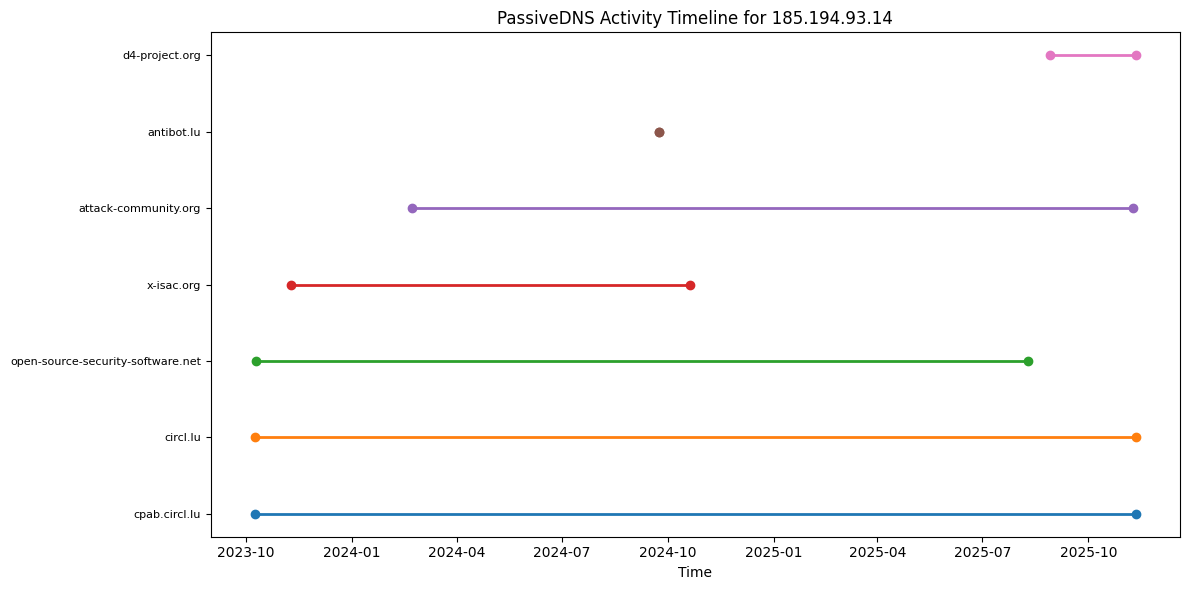

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

ip = "185.194.93.14"
records = pdns.iter_query(q=ip)
df = pd.DataFrame([r.record for r in records])

df["time_first_dt"] = pd.to_datetime(df["time_first"], unit="s")
df["time_last_dt"]  = pd.to_datetime(df["time_last"], unit="s")

# Optional: Keep only unique rrname/rdata pairs
df = df.drop_duplicates(subset=["rrname", "rdata"])

# Sort and index
df = df.sort_values("time_first_dt").reset_index(drop=True)

# Plot timeline
plt.figure(figsize=(12, 6))

for i, row in df.iterrows():
    plt.plot([row["time_first_dt"], row["time_last_dt"]], [i, i], 'o-', lw=2)
    
# Label each Y tick with rrname or rdata
plt.yticks(range(len(df)), df["rdata"], fontsize=8)
plt.xlabel("Time")
plt.title(f"PassiveDNS Activity Timeline for {ip}")
plt.tight_layout()
plt.show()

### Homework - Domain investigation
- Pick a domain (not `circl.lu`) and perform the following using the notebook's pdns client.

1. Query A and AAAA records for the domain and list all unique IPv4 and IPv6 addresses you find.
2. Choose one IPv4 address from the results and run a reverse lookup to list all domains that have resolved to it.
3. Create a DNS activity timeline for that chosen IP (use the timeline plotting cell as a template).
4. Answer the short questions:
    - How many unique IPs serve the domain?
    - Is IPv6 supported?
    - Does the reverse lookup suggest shared hosting or a single-tenant IP?

Hints:
- Use pdns.iter_query(q=domain, filter_rrtype='A') and filter_rrtype='AAAA'.
- Collect rdata values for unique IPs and rrname for domains from reverse lookups.
- Reuse the existing timeline plotting code cell and swap the IP variable.

In [ ]:

# Your code here...
